In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np

import json
import pandas as pd
import nltk
import re

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn import preprocessing

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Задание 1

Решите задачу расшифровки сообщения с помощью RNN. Представьте, что вам даны сообщения, зашифрованные с помощью шифра Цезаря, являющимся одним из самый простых шифров, в криптографии.
Шифр цезаря работает следующим образом: каждая буква исходного алфавита сдвигается на K символов вправо:
Пусть нам дано сообщение: message="RNN IS NOT AI", тогда наше шифрование выполняющиеся по правилу f, с K=2, даст нам результат: f(message, K) = TPPAKUAPQVACK


In [2]:
# Определим ключ и словарь
key = 2
vocab = [char for char in ' -ABCDEFGHIJKLMNOPQRSTUVWXYZ']

In [3]:
def encrypt(text, key):
    """Returns the encrypted form of 'text'."""
    indexes = [vocab.index(char) for char in text]
    encrypted_indexes = [(idx + key) % len(vocab) for idx in indexes]
    encrypted_chars = [vocab[idx] for idx in encrypted_indexes]
    encrypted = ''.join(encrypted_chars)
    return encrypted

In [4]:
def encrypted_dataset(dataset_len, k):
    """
    Return: List(Tuple(Tensor encrypted, Tensor source))
    """
    dataset = []
    for x in range(dataset_len):
        random_message  = ''.join([random.choice(vocab) for x in range(seq_len)])
        encrypt_random_message = encrypt(''.join(random_message), k)
        src = [vocab.index(x) for x in random_message]
        tgt = [vocab.index(x) for x in encrypt_random_message]
        dataset.append([torch.tensor(tgt), torch.tensor(src)])
    return dataset

In [5]:
class Decipher(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim,
                 rnn_type='simple'):
        """
        :params: int vocab_size
        :params: int embedding_dim
        :params
        """
        super(Decipher, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == 'simple':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers = 2)

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.initial_hidden = torch.zeros(2, 1, hidden_dim)


    def forward(self, cipher):
        # CHECK INPUT SIZE
        # Unsqueeze 1 dimension for batches
        embd_x = self.embed(cipher).unsqueeze(1)
        out_rnn, hidden = self.rnn(embd_x, self.initial_hidden)
        # Apply the affine transform and transpose output in appropriate way
        # because you want to get the softmax on vocabulary dimension
        # in order to get probability of every letter
        return self.fc(out_rnn).transpose(1, 2)

In [6]:
num_examples = 256 # размер датасета
seq_len = 18 # максимальная длина строки

# определим параметры нашей модели
embedding_dim = 5
hidden_dim = 10
vocab_size = len(vocab)
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()

# Инициализируйте модель
model = Decipher(vocab_size, embedding_dim, hidden_dim)

# Инициализируйте оптимизатор: рекомендуется Adam
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

num_epochs = 10

In [7]:
k = 10
for x in range(num_epochs):
    print('Epoch: {}'.format(x))
    for encrypted, original in encrypted_dataset(num_examples, k):

        scores = model(encrypted)
        original = original.unsqueeze(1)
        # Calculate loss
        loss = criterion(scores, original)
        # Zero grads
        optimizer.zero_grad()
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
    print('Loss: {:6.4f}'.format(loss.item()))

    with torch.no_grad():
        matches, total = 0, 0
        for encrypted, original in encrypted_dataset(num_examples, k):
            # Compute a softmax over the outputs
            predictions = F.softmax(model(encrypted), 1)
            # Choose the character with the maximum probability (greedy decoding)
            _, batch_out = predictions.max(dim=1)
            # Remove batch
            batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, original).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total
        print('Accuracy: {:4.2f}%'.format(accuracy * 100))

Epoch: 0
Loss: 2.7818
Accuracy: 28.84%
Epoch: 1
Loss: 1.7837
Accuracy: 66.71%
Epoch: 2
Loss: 1.2635
Accuracy: 86.20%
Epoch: 3
Loss: 0.8769
Accuracy: 93.14%
Epoch: 4
Loss: 0.5369
Accuracy: 96.61%
Epoch: 5
Loss: 0.5034
Accuracy: 96.57%
Epoch: 6
Loss: 0.3278
Accuracy: 96.05%
Epoch: 7
Loss: 0.2534
Accuracy: 96.59%
Epoch: 8
Loss: 0.2072
Accuracy: 100.00%
Epoch: 9
Loss: 0.1445
Accuracy: 100.00%


# Задание 2

Примените RNN к классификации текстов из лабораторной работы №1 (на несбалансированных и балансированных классах). Сравните результаты с классическими методами машинного обучения. Сделайте выводы!

In [16]:
lr = 0.001
batch_size = 200
num_epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

## Вспомогательные ф-ции

In [2]:
def pad_features(int_vector, max_len):
    if (len(int_vector) <= max_len):
      zeros = list(np.zeros(max_len - len(int_vector)).astype(int))
      new = zeros + int_vector
    else:
      new = int_vector[: max_len]
    return new

In [3]:
def text2num(text, num_dict):
    text = [num_dict[i] for i in text.split()]
    return text

In [4]:
def clean_text(text):
    stemmer = SnowballStemmer('russian')
    stop_words = set(stopwords.words('russian'))
    lemmatizer = WordNetLemmatizer()    
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.lower()
    text = word_tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    text = [word for word in text if len(word) > 2 and len(word) < 20]
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    return text

In [33]:
def prepare_data(header, review, head_dict, rev_dict):
    header = clean_text(header)
    review = clean_text(review)
    header = text2num(header, head_dict)
    review = text2num(review, rev_dict)
    header = pad_features(header, 15)
    review = pad_features(review, 400)
    return torch.unsqueeze(torch.tensor(header), dim=0), torch.unsqueeze(torch.tensor(review), dim=0)

In [6]:
class ToTensor:
  def __init__(self):
    pass
    # Convert series to cuda-Tensors
  def __call__(self, sample):
      inputs, inputs2, targets = sample
      return torch.tensor(inputs), torch.tensor(inputs2), torch.tensor([float(i) for i in targets])

In [7]:
class GetFeaturesFromRNN(torch.nn.Module):
  def forward(self, x):
    x, _ = x
    if len(x.shape) == 3:
        return x[:, -1, :]
    elif len(x.shape) == 2:
        return x[:, -1]

In [8]:
class EarlyStopping():
  def __init__(self, min_delta=0.001, tolerance=15):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.flag = False
    self.min_loss = float('inf')

  def __call__(self, val_loss):
    if (val_loss - self.min_loss) > self.min_delta:
      self.counter += 1
      if self.counter >= self.tolerance:
        self.flag = True
    self.min_loss = val_loss if val_loss < self.min_loss else self.min_loss

In [9]:
def train_one_epoch(model, train_dataloader, loss_func, optimizer, device):
  model.train()
  epoch_loss = []
  for (local_head_batch, local_rev_batch, local_label) in train_dataloader:
    (local_head_batch, local_rev_batch, local_label) = (local_head_batch.to(device), local_rev_batch.to(device), local_label.to(device))
    optimizer.zero_grad()
    y_pred = model.forward(local_head_batch, local_rev_batch)
    #print(y_pred,"\n\n\n", local_label)
    curr_loss = criterion.forward(y_pred, local_label)
    curr_loss.backward()
    optimizer.step()
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

#use with torch.no_grad()
def val_one_epoch(model, val_dataloader, loss_func, device):
  model.eval()
  epoch_loss = []
  for (local_head_batch, local_rev_batch, local_label) in val_dataloader:
    (local_head_batch, local_rev_batch, local_label) = (local_head_batch.to(device), local_rev_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_head_batch, local_rev_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

def test_model(model, test_dataloader, device, classes):
  model.eval()
  test_hits = 0
  total = 0
  confusion_matrix = torch.zeros(len(classes), len(classes))
  for (local_head_batch, local_rev_batch, local_label) in test_dataloader:
    (local_head_batch, local_rev_batch, local_label) = (local_head_batch.to(device), local_rev_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_head_batch, local_rev_batch)
    _, preds = torch.max(y_pred, 1)
    #print(preds.view(-1))
    #print(preds.view(-1).shape, local_label.view(-1).shape)
    test_hits += torch.sum(preds.view(-1) == torch.max(local_label, 1)[1].view(-1))
    total += torch.numel(preds.view(-1))
    for t, p in zip(torch.max(local_label, 1)[1].view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix, test_hits, total

## Модель

In [10]:
class Classificator(torch.nn.Module):
  def __init__(self, output_dim,
               vocab_head_size, embedding_head_dim,
               vocab_rev_size, embedding_rev_dim):
    super(Classificator, self).__init__()
    self.head_features = nn.Sequential(
        nn.Embedding(vocab_head_size+1, embedding_dim=embedding_head_dim),
        nn.LSTM(embedding_head_dim, 256, num_layers=2, batch_first=True, dropout=0.5),
        GetFeaturesFromRNN()
    )
    self.review_features = nn.Sequential(
        nn.Embedding(vocab_rev_size+1, embedding_dim=embedding_rev_dim),
        nn.LSTM(embedding_rev_dim, 1024, num_layers=3, batch_first=True, dropout=0.5),
        GetFeaturesFromRNN()
    )
    self.fc = nn.Sequential(
        nn.Linear(1024+256, (1024+256)*2),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear((1024+256)*2, output_dim),
        nn.LogSoftmax(dim=1)
    )


  def forward(self, x0, x1):
    x0 = self.head_features.forward(x0)
    x1 = self.review_features.forward(x1)
    x = torch.cat((x0, x1), 1)
    x = self.classificator(x)
    return x

## Датасет

In [11]:
# создание датасета

class Dataset(torch.utils.data.Dataset):
  def __init__(self, transform=None, verbose=False, convert=False, oversample=False):

    f = open(r"C:\Users\user\Desktop\dz\nlp\data\filename.json", "r")
    json_data = json.load(f)
    f.close()

    xy = pd.DataFrame()

    xy['revVal'] = pd.Series([json['reviewRating']['ratingValue'] for json in json_data]).astype('int32')
    xy['header'] = [json['name'] for json in json_data]
    xy['review'] = [json['author']['reviewBody'] for json in json_data]
      
    if oversample:
        max_size = xy['revVal'].value_counts().max()
        lst = [xy]
        for class_index, group in xy.groupby('revVal'):
            lst.append(group.sample(max_size-len(group), replace=True))
        xy = pd.concat(lst)

    if convert:
      stemmer = SnowballStemmer('russian')
      stop_words = set(stopwords.words('russian'))
      lemmatizer = WordNetLemmatizer()

      xy['review'] = xy['review'].apply(clean_text)
      xy['header'] = xy['header'].apply(clean_text)

      self.rev_dict = {val: key + 1 for key, val in enumerate(set(" ".join(xy['review'].to_list()).split()))}
      self.head_dict = {val: key + 1 for key, val in enumerate(set(" ".join(xy['header'].to_list()).split()))}

      xy['review'] = xy['review'].apply(text2num, num_dict=self.rev_dict)
      xy['header'] = xy['header'].apply(text2num, num_dict=self.head_dict)

      xy['length_rev'] = xy.review.map(len)
      max_len_rev = xy['length_rev'].max()

      xy['length_head'] = xy.header.map(len)
      max_len_head = xy['length_head'].max()

      xy['review'] = xy['review'].apply(pad_features, max_len=max_len_rev)
      xy['header'] = xy['header'].apply(pad_features, max_len=max_len_head)

      def target_to_list(target):
        dummy = [0, 0, 0, 0, 0]
        dummy[target-1] = 1
        return dummy

      xy['revVal'] = xy['revVal'].apply(target_to_list)
    
        
    self.data = xy
    self.n_samples = xy.shape[0]
    self.y_data = xy['revVal']
    self.x_rev_data = xy['review']
    self.x_head_data = xy['header']

    if verbose:
      print(f'y shape: {self.y_data.shape}')
      print(f'x shape: {self.x_data.shape}')

    self.transform = transform

  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx):
    sample = self.x_head_data.iloc[idx],self.x_rev_data.iloc[idx],  self.y_data.iloc[idx]

    if self.transform:
      sample = self.transform(sample)

    return sample

## Загрузка и подготовка данных

In [12]:
to_tensor = ToTensor()
dataset = Dataset(transform=transforms.Compose([to_tensor]), convert=True, oversample=True)

In [17]:
train_size = int(0.8*len(dataset))
val_size = int(0.1*len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [18]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=0)

## Загрузка и подготовка модели

In [19]:
vocab_rev_size = len(dataset.rev_dict)
vocab_head_size = len(dataset.head_dict)

embedding_head_dim = 50
embedding_rev_dim = 300

output_dim = 5

In [20]:
model = Classificator(output_dim,
                      vocab_head_size, embedding_head_dim,
                      vocab_rev_size, embedding_rev_dim).to(device)

In [21]:
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 30580989


In [22]:
next(model.parameters()).is_cuda

True

## Обучение модели

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
)
early_stopping = EarlyStopping(min_delta=0.01, tolerance=15)

In [24]:
train_loss = []
val_loss = []
for epoch in tqdm(range(num_epochs)):
  epoch_train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)
  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, val_loader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None


early stop at epoch №23


<Axes: >

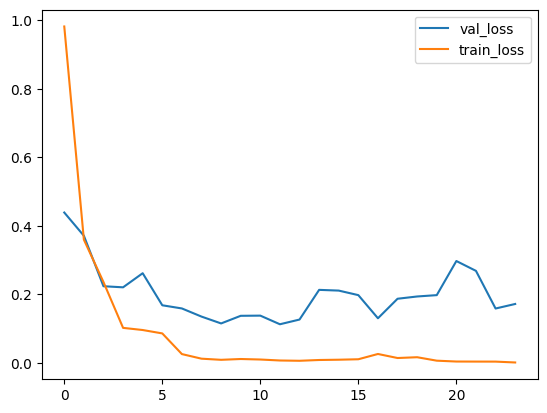

In [41]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

## тест модели

In [27]:
with torch.no_grad():
    test_data = test_model(model, test_loader, device, [1, 2, 3, 4, 5])
torch.cuda.empty_cache() if device == 'cuda' else None

In [28]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 97.79%


<Axes: >

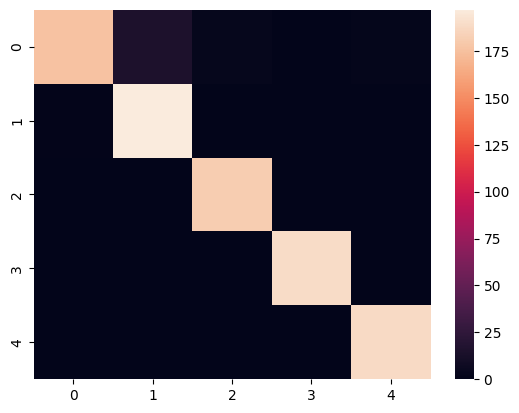

In [29]:
from seaborn import heatmap
heatmap(test_data[0])

In [30]:
# так как модель нас устраивает, то сохраняем ее

In [31]:
torch.save(model.state_dict(), r'C:\Users\user\Desktop\dz\nlp\lab3\files\model_lab3.pth')
torch.save(optimizer.state_dict(), r'C:\Users\user\Desktop\dz\nlp\lab3\files\optimizer_lab3.pth')

In [32]:
with open(r'C:\Users\user\Desktop\dz\nlp\lab3\files\head_dict.json', 'w') as f:
    json.dump(dataset.head_dict, f)
with open(r'C:\Users\user\Desktop\dz\nlp\lab3\files\rev_dict.json', 'w') as f:
    json.dump(dataset.rev_dict, f)

## Загрузка и использование модели

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
f = open(r'C:\Users\user\Desktop\dz\nlp\lab3\files\head_dict.json', "r")
head_dict = json.load(f)
f.close()

In [36]:
f = open(r'C:\Users\user\Desktop\dz\nlp\lab3\files\rev_dict.json', "r")
rev_dict = json.load(f)
f.close()

In [37]:
vocab_rev_size = len(rev_dict)
vocab_head_size = len(head_dict)

embedding_head_dim = 50
embedding_rev_dim = 300

output_dim = 5

In [38]:
model = Classificator(output_dim,
                      vocab_head_size, embedding_head_dim,
                      vocab_rev_size, embedding_rev_dim).to(device)
model.load_state_dict(torch.load(r'C:\Users\user\Desktop\dz\nlp\lab3\files\model_lab3.pth'))
model.eval()

Classificator(
  (head_features): Sequential(
    (0): Embedding(2040, 50)
    (1): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.5)
    (2): GetFeaturesFromRNN()
  )
  (review_features): Sequential(
    (0): Embedding(13734, 300)
    (1): LSTM(300, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (2): GetFeaturesFromRNN()
  )
  (classificator): Sequential(
    (0): Linear(in_features=1280, out_features=2560, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2560, out_features=5, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [45]:
header = "Просрочка в один день, дезинформация в чате банка"
review = "Здравствуйте? 06.02.23 по графику был очередной платеж по потребительскому кредиту 17 236р., по ошибке на счете не оказалось нужной суммы и банк списал 17 100р., 136р. вышли на просрочку. Просрочку я обнаружил утром 07.02.23 и сразу внес недостающую сумму, о чем сообщил в чате приложения банка. Оператор информацию принял, и заверил что данная просрочка не попадет в кредитную историю (Скрины могу предоставить). Сегодня проверил КИ и обнаружил данную просрочку, на фоне всех остальных своевременных платежей по графику. Связался в чате приложения с оператором, оператор в свою очередь дал мне стандартный ответ, что все просрочки попадают в КИ и направил меня по всем вопросам связанным с корректировкой КИ в НБКИ. Прошу рассмотреть корректировку данной просрочки в индивидуальном порядке, т.к. считаю что сумма и срок незначительные, а кредитный рейтинг при этом снижается на 40 пунктов, что очень важно в данный момент для меня. Обязательства перед банком выполняю в полном объеме и своевременно. "
#revVal = 3
header, review = prepare_data(header, review, head_dict, rev_dict)
with torch.no_grad():
    y_pred = model.forward(header.to(device), review.to(device))
    _, preds = torch.max(y_pred, 1)
    print(f'predicted score = {preds.item()}')

predicted score = 2


## Выводы по заданию

Точность сильно поднялась, по сравнению с прошлым решением задачи, так как был использован более подходящий для этой задачи стек технологий. Эмбединги и рекурентность позволили нам принимать во внимание не только частоту слов, но и создавать смысловые веса, которые определяются по соседям, улучшить модель можно, меняя различные параметры и/или добавляя новые слои

# Задание 3

Для настоящего корпуса собраний сочинений Федора Михайловича Достоевского сделайте следующие задания:
Сколько слов и предложений в датасете?
Каковы частоты для слов «бесы», «семья», «брат». Введите значение, округленное до 5 знаков?
Сгенерируйте текст, который состоит из слов с вероятностями появления от 0. 85 до 0.95 и итоговое предложение состоит из 10 слов.


## Подготовка к заданию

In [ ]:
f = open('dostoevsky.txt', 'r', encoding='utf-8')
text = f.read()

## Сколько слов и предложений в датасете?

In [ ]:
import nltk
import re

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('russian')
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  text = re.sub(r'[^\w\s]', ' ', text)
  text = re.sub(r'\d+', ' ', text)
  text = text.lower()
  text = word_tokenize(text)
  text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
  text = [stemmer.stem(word) for word in text]
  text = ' '.join(text)
  return text

In [ ]:
from nltk import word_tokenize
text_tokens = word_tokenize(clean_text(text))
print('words counter: ', len(text_tokens))

In [ ]:
from nltk.tokenize import sent_tokenize
print('sentences counter: ', len(sent_tokenize(text)))

## Каковы частоты для слов «бесы», «семья», «брат». Введите значение, округленное до 5 знаков?

In [ ]:
text = nltk.Text(text_tokens)

In [ ]:
from nltk.probability import FreqDist
fdist = FreqDist(text)

In [ ]:
print(f"бесы - {round(fdist[clean_text('бесы')]/len(text_tokens), 5)}, семья - {round(fdist[clean_text('семья')]/len(text_tokens), 5)}, брат - {round(fdist[clean_text('брат')]/len(text_tokens), 5)}")

## Сгенерируйте текст, который состоит из слов с вероятностями появления от 0. 85 до 0.95 и итоговое предложение состоит из 10 слов.

считаю, что задание составленно некорректно (или не достаточно прояснено), так как основываясь на том, что у нас имеется, слово "и" является самым частым в данном корпусе с частотой  = 0.0448 => вероятность появления "и" на одной из 10 позиций с повторением (т.е. в рассчет берется тот факт, что слово "и" может повторяться в предложении) рассчитвается по ф-ле $P = 1 - (1 - p_i)^l; l - $кол-во позиций в предложении

In [ ]:
fdist.most_common(1)[0][1]/len(text_tokens)